# CommonLit | TF-IDF & XGB Baseline

# 1. Libraries

In [1]:
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 7.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.3/289.3 kB 7.3 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 23.1.2 -> 23.2.1
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [2]:
import os
import re
import nltk
import string
import warnings
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings('ignore')

In [11]:
class config:
    sample_submission_path = 'commonlit-evaluate-student-summaries/sample_submission.csv'
    prompts_train_path = 'commonlit-evaluate-student-summaries/prompts_train.csv'
    summaries_test_path = 'commonlit-evaluate-student-summaries/summaries_test.csv'
    summaries_train_path = 'commonlit-evaluate-student-summaries/summaries_train.csv'
    prompts_test_path = 'commonlit-evaluate-student-summaries/prompts_test.csv'

# 2. Loading Data

In [12]:
sample_submission = pd.read_csv(config.sample_submission_path)
prompts_train = pd.read_csv(config.prompts_train_path)
summaries_test = pd.read_csv(config.summaries_test_path)
summaries_train = pd.read_csv(config.summaries_train_path)
prompts_test = pd.read_csv(config.prompts_test_path)

print(f'sample_submission shape: {sample_submission.shape}')
print(f'prompts_train shape: {prompts_train.shape}')
print(f'summaries_test shape: {summaries_test.shape}')
print(f'summaries_train shape: {summaries_train.shape}')
print(f'prompts_test shape: {prompts_test.shape}')
print('-'*90)
print(f'sample_submission missing values: {sample_submission.isnull().sum().sum()}')
print(f'prompts_train missing values: {prompts_train.isnull().sum().sum()}')
print(f'summaries_test missing values: {summaries_test.isnull().sum().sum()}')
print(f'summaries_train missing values: {summaries_train.isnull().sum().sum()}')
print(f'prompts_test missing values: {prompts_test.isnull().sum().sum()}')
print('-'*90)
summaries_train.head()

sample_submission shape: (4, 3)
prompts_train shape: (4, 4)
summaries_test shape: (4, 3)
summaries_train shape: (7165, 5)
prompts_test shape: (2, 4)
------------------------------------------------------------------------------------------
sample_submission missing values: 0
prompts_train missing values: 0
summaries_test missing values: 0
summaries_train missing values: 0
prompts_test missing values: 0
------------------------------------------------------------------------------------------


,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


# 3. Target Distribution

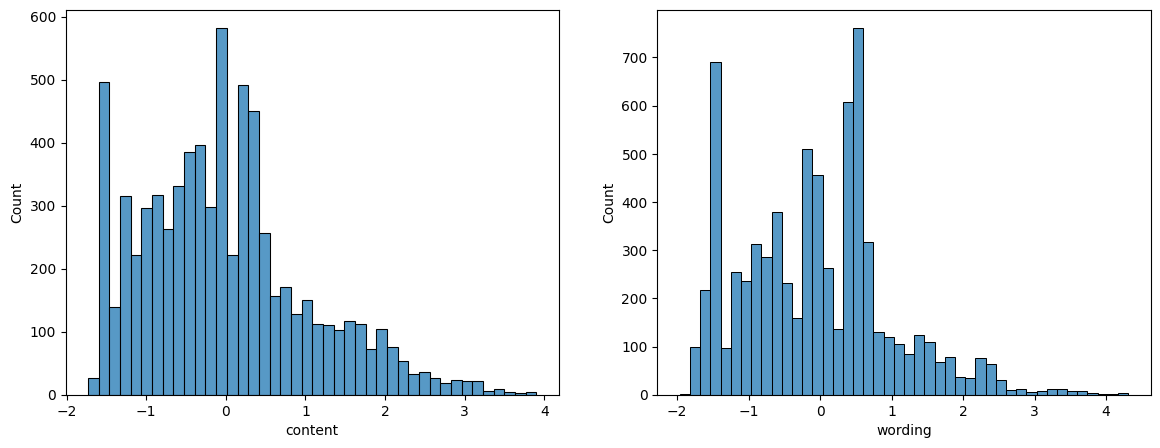

In [13]:
plt.figure(figsize = (14, 5))
plt.subplot(1, 2, 1)
sns.histplot(data=summaries_train, x='content')
plt.subplot(1, 2, 2)
sns.histplot(data=summaries_train, x='wording')
plt.show()

# 4. Feature Engineering

In [14]:
def clean_text(text: str) -> str:
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

def count_total_words(text: str) -> int:
    words = text.split()
    total_words = len(words)
    return total_words

def count_stopwords(text: str) -> int:
    stopword_list = set(stopwords.words('english'))
    words = text.split()
    stopwords_count = sum(1 for word in words if word.lower() in stopword_list)
    return stopwords_count

def count_punctuation(text: str) -> int:
    punctuation_set = set(string.punctuation)
    punctuation_count = sum(1 for char in text if char in punctuation_set)
    return punctuation_count

def count_numbers(text: str) -> int:
    numbers = re.findall(r'\d+', text)
    numbers_count = len(numbers)
    return numbers_count

def feature_engineer(dataframe: pd.DataFrame, feature: str = 'text') -> pd.DataFrame:
    dataframe[f'{feature}_length'] = dataframe[feature].apply(lambda x: len(x))
    dataframe[f'{feature}_word_cnt'] = dataframe[feature].apply(lambda x: count_total_words(x))
    dataframe[f'{feature}_stopword_cnt'] = dataframe[feature].apply(lambda x: count_stopwords(x))
    dataframe[f'{feature}_punct_cnt'] = dataframe[feature].apply(lambda x: count_punctuation(x))
    dataframe[f'{feature}_number_cnt'] = dataframe[feature].apply(lambda x: count_numbers(x))
    return dataframe

In [28]:
import nltk
nltk.download('stopwords')
summaries_train = feature_engineer(summaries_train)
summaries_test = feature_engineer(summaries_test)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jmj3047/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
import nltk
nltk.download('stopwords')

vectorizer = TfidfVectorizer(encoding='utf-8',
                             ngram_range=(1, 1),
                             lowercase=True,
                             stop_words=list(stopwords.words('english')),
                             max_features=250)

train_vectorized = pd.DataFrame(
                vectorizer.fit_transform(summaries_train['text']).toarray(),
                columns=[f"tfidf_{str(f)}" for f in vectorizer.get_feature_names_out()],
            )

test_vectorized = pd.DataFrame(
                vectorizer.transform(summaries_test['text']).toarray(),
                columns=[f"tfidf_{str(f)}" for f in vectorizer.get_feature_names_out()],
            )

summaries_train = pd.concat([summaries_train, train_vectorized], axis=1)

summaries_test = pd.concat([summaries_test, test_vectorized], axis=1)

summaries_train.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jmj3047/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,student_id,prompt_id,text,content,wording,text_length,text_word_cnt,tfidf_able,tfidf_according,tfidf_actions,...,tfidf_well,tfidf_whenever,tfidf_white,tfidf_whole,tfidf_work,tfidf_worked,tfidf_workers,tfidf_working,tfidf_would,tfidf_write
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,346,61,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,244,52,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.252892,0.0,0.425880,0.000000
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,1370,235,0.114092,0.0,0.0,...,0.089862,0.0,0.0,0.0,0.091531,0.0,0.090915,0.0,0.306210,0.116408
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,157,25,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,1225,203,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.159293,0.000000


In [30]:
features = summaries_train.drop(columns = ['student_id', 'prompt_id', 'text', 'content', 'wording'], axis = 1).columns

# 5. Modeling

In [31]:
# features()
summaries_test[features]

,text_length,text_word_cnt,tfidf_able,tfidf_able,tfidf_according,tfidf_according,tfidf_actions,tfidf_actions,tfidf_also,tfidf_also,...,tfidf_worked,tfidf_worked,tfidf_workers,tfidf_workers,tfidf_working,tfidf_working,tfidf_would,tfidf_would,tfidf_write,tfidf_write
0,14,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,14,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,14,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,14,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
N_FOLDS = 10
SEED = 42
NUM_ROUNDS = 5000
EARLY_STOPPING_ROUNDS = 500
VERBOSE = 500

params = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'sampling_method': 'uniform',
    'tree_method': 'gpu_hist',
    'learning_rate': 0.008,
    'max_depth': 6,
    'subsample': 0.78,
    'min_child_weight': 5
    
}

for target in ['content', 'wording']:
    X = summaries_train[features]
    y = summaries_train[target]
    X_test = summaries_test[features]
    y_test = np.zeros(shape=summaries_test.shape[0], dtype=float)
    dtest = xgb.DMatrix(data=X_test)
    
    cv = KFold(n_splits = N_FOLDS, shuffle = True, random_state = SEED)
    for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
        print(f"| Target: {target} - Fold {idx+1} |".center(80, "-"))
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]
        print(f'train: {X_train.shape}')
        print(f'val: {X_val.shape}')
        dtrain = xgb.DMatrix(data=X_train, label=y_train)
        dval = xgb.DMatrix(data=X_val, label=y_val)
        
        model = xgb.train(params=params,
                          dtrain=dtrain,
                          evals=[(dtrain, 'train'), (dval, 'validation')],
                          num_boost_round=NUM_ROUNDS,
                          early_stopping_rounds=EARLY_STOPPING_ROUNDS,
                          verbose_eval=VERBOSE)
        
        y_test += model.predict(dtest) / N_FOLDS
    sample_submission[target] = y_test

ValueError: feature_names must be unique

In [10]:
sample_submission

,student_id,content,wording
0,000000ffffff,-1.634779,-1.571156
1,111111eeeeee,-1.634779,-1.571156
2,222222cccccc,-1.634779,-1.571156
3,333333dddddd,-1.634779,-1.571156


In [11]:
sample_submission.to_csv('submission.csv', index=False)